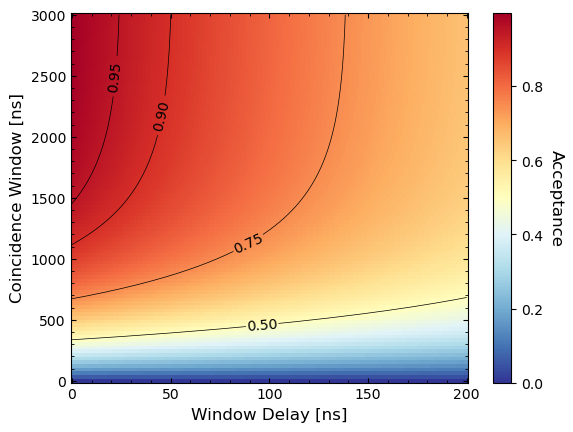

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib.ticker import MultipleLocator

def acceptance_function(mean_lifetime, coincidence_start_time, coincidence_window):
    epsilon = 1e-10
    first_exp = np.exp(-coincidence_start_time / (mean_lifetime + epsilon))
    second_exp = np.exp(-(coincidence_start_time + coincidence_window) / (mean_lifetime + epsilon))
    return first_exp - second_exp

# Define the parameter values
mean_lifetime = 336 / np.log(2) # ns
coincidence_start_time_range = np.linspace(0, 200, 1000)  # ns
coincidence_window_range = np.linspace(0, 3000, 1000)  # ns

# Create a meshgrid of coincidence start times and coincidence windows
coincidence_start_time, coincidence_window = np.meshgrid(coincidence_start_time_range, coincidence_window_range)

# Compute the acceptance function for each combination of start time and window
acceptance = acceptance_function(mean_lifetime, coincidence_start_time, coincidence_window)

# Define the regular grid onto which to interpolate the data
nx, ny = 200, 100
xmin, xmax = coincidence_start_time_range.min(), coincidence_start_time_range.max()
ymin, ymax = coincidence_window_range.min(), coincidence_window_range.max()
xi = np.linspace(xmin, xmax, nx)
yi = np.linspace(ymin, ymax, ny)
xi, yi = np.meshgrid(xi, yi)

# Interpolate the data onto the regular grid
zi = griddata((coincidence_start_time.flatten(), coincidence_window.flatten()), acceptance.flatten(), (xi, yi), method='linear')

# Create a contour plot of acceptance as a function of start time and window
fig, ax = plt.subplots()
labels = [0.5, 0.75, 0.9, 0.95]
label_locations = [(97, 300), (90, 1100), (40, 2200), (20, 2500)]

cs = ax.contour(xi, yi, zi, levels=labels, linewidths=0.5, colors='k')
ax.clabel(cs, inline=True, fontsize=10, fmt='%1.2f', manual=label_locations, levels=labels)

im = ax.pcolormesh(xi, yi, zi, cmap='RdYlBu_r', shading='auto')

# Set x and y tick positions and labels
ax.set_xticks(np.arange(0, 201, 50))
ax.set_xticks(np.arange(0, 201, 10), minor=True)
ax.set_yticks(np.arange(0, 3001, 500))
ax.set_yticks(np.arange(0, 3001, 100), minor=True)
ax.xaxis.set_major_locator(MultipleLocator(50))
ax.yaxis.set_major_locator(MultipleLocator(500))
ax.tick_params(axis='both', which='both', direction='in', labelsize=10, top=True, right=True)

# Set x and y axis labels and title
ax.set_xlabel('Window Delay [ns]', fontsize=12)
ax.set_ylabel('Coincidence Window [ns]', fontsize=12)

# Add a colorbar to the plot
cbar = fig.colorbar(im)
cbar.ax.set_ylabel('Acceptance', rotation=270, labelpad=15, fontsize=12)

plt.show()

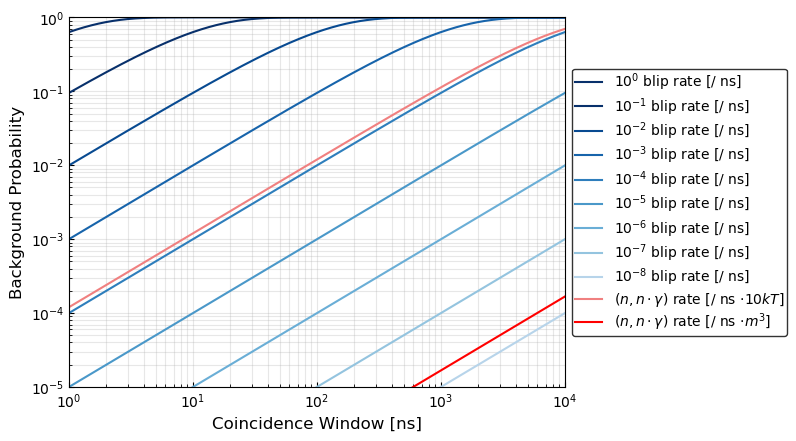

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

def background_function(background_rate, coincidence_window):
    background_prob = 1 - np.exp(-background_rate * coincidence_window)
    return background_prob

# Define the parameter values
background_rate_range = [1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]  # blip rate / ns
coincidence_window_range = np.logspace(-1, 4, 10000)  # ns

# https://arxiv.org/pdf/2203.08821.pdf
# https://indico.cern.ch/event/835190/contributions/3613929/attachments/1940605/3217578/NNN_presentation.pdf
neutron_inelastic_rate = 12*1e2*1e-7 # / ns 10kT
lar_density = 1396 # kg / m^3
neutron_inelastic_rate_per_m3 = neutron_inelastic_rate * lar_density / 10000000 # /ns m^3

# Compute the background probability for each background rate
background_prob_rates = []
for background_rate in background_rate_range:
    background_prob = background_function(background_rate, coincidence_window_range)
    background_prob_rates.append(background_prob)

# Create a log-log plot of background probability as a function of coincidence window
fig, ax = plt.subplots()

colors = plt.cm.Blues(np.linspace(0.3, 1.1, len(background_prob_rates)))
colors = colors[::-1] # reverse the order to go from darker to lighter blue colors
labels = [r'$10^{0}$ blip rate [/ ns]', r'$10^{-1}$ blip rate [/ ns]', r'$10^{-2}$ blip rate [/ ns]', r'$10^{-3}$ blip rate [/ ns]', r'$10^{-4}$ blip rate [/ ns]', r'$10^{-5}$ blip rate [/ ns]',  r'$10^{-6}$ blip rate [/ ns]', r'$10^{-7}$ blip rate [/ ns]', r'$10^{-8}$ blip rate [/ ns]']

for i in range(len(background_prob_rates)):
    ax.plot(coincidence_window_range, background_prob_rates[i], color=colors[i], label=labels[i])

# Add neutron inelastic scattering rate plot
neutron_prob = background_function(neutron_inelastic_rate, coincidence_window_range)
ax.plot(coincidence_window_range, neutron_prob, color='lightcoral', label=r'$(n, n \cdot \gamma)$ rate [/ ns $\cdot 10kT$]')

neutron_prob_per_m3 = background_function(neutron_inelastic_rate_per_m3, coincidence_window_range)
ax.plot(coincidence_window_range, neutron_prob_per_m3, color='red', label=r'$(n, n \cdot \gamma)$ rate [/ ns $\cdot m^3$]')

ax.set_xlabel('Coincidence Window [ns]', fontsize=12)
ax.set_ylabel('Background Probability', fontsize=12)

ax.set_xscale('log')
ax.set_yscale('log')

ax.legend(fontsize=10, loc='center left', bbox_to_anchor=(1, 0.5), frameon=True, labelspacing=0.2, borderpad=0.2, edgecolor='black', facecolor='white')
# Set ticks inside the plot
ax.tick_params(direction='in', which='both', labelsize=10)

# Show grid lines
ax.grid(True, which='both', alpha=0.3)

ax.set_ylim([1e-5, 1])
ax.set_xlim([1, 10000])

plt.show()